In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import helper  # courtesy of CS109B

## Image Classification: FFNN vs CNN

In this exercise we'll train a neural network to discriminate between two images.

Pavlos          |  Not Pavlos
:-------------------------:|:-------------------------:
![title](data/pavlos.jpeg) |![title](data/not-pavlos.jpeg)

Surely this'll be simple task with only two images! But there's a catch. We'll be using an image generator to create 'translated' versions of our two images. That is, images shifted up or down, left or right. This way every image the network sees will be a novel variation on one of the two original images.

### Image Generator

Let's load the generator that will provider our models with the random variations.

In [3]:
img_generator = helper.get_generator()

print(f'Classes: {img_generator.class_indices}')

TARGET_SIZE = img_generator.target_size
print(f'Generator produces images of size {TARGET_SIZE} (with 3 color channels)')

BATCH_SIZE = img_generator.batch_size
print(f'Images are generated in batches of size {BATCH_SIZE}')

Found 290 images belonging to 2 classes.
Classes: {'pavlos': 0, 'not-pavlos': 1}
Generator produces images of size (150, 150) (with 3 color channels)
Images are generated in batches of size 16


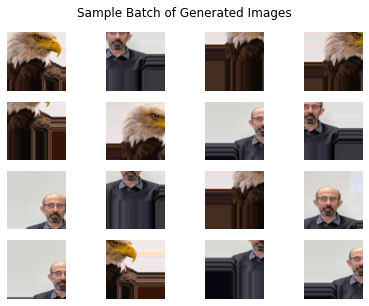

In [4]:
sample_batch = img_generator.next()[0]
fig, ax = plt.subplots(4,4)
ax = ax.ravel()
for i, img in enumerate(sample_batch):
    ax[i].set_axis_off()
    ax[i].imshow(img)
plt.suptitle('Sample Batch of Generated Images', y=1.05)
plt.tight_layout()

### Feed-Forward Neural Network

Our first network will be a feed-forward neural network. The only layers with learned parameters we will be using are dense layers.

In [19]:
FFNN = Sequential()
# compare input_shape to TARGET_SIZE above
FFNN.add(Input(shape=(150, 150, 3)))
# fill in the layer needed at the beginning of our FFNN for it to process images
# Ex: FFNN.add(Somelayer())  
# Hint: check the imports above
#FFNN.add(__)
FFNN.add(Flatten())
# specify a list of the number of nodes for each dense layer
# you can try any number of dense layers with any number of nodes in each
# Ex: for n_nodes in [a,b,c,...] where a, b, c, etc. are ints
for n_nodes in [1, 2, 3]:
    FFNN.add(Dense(n_nodes, activation='relu'))
FFNN.add(Dense(1, activation='sigmoid'))

FFNN.compile(loss='binary_crossentropy', metrics=['accuracy'])

Think about how do your choices for number of nodes and layers affect the total number of learned parameters.

Think about - Can your FFNN do better than chance guessing after 10 epochs. 

For a real challenge, see if you can do it with fewer than 5 million parameters.

In [20]:
FFNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 67501     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 4         
Total params: 67,518
Trainable params: 67,518
Non-trainable params: 0
_________________________________________________________________


In [21]:
FFNN_history = FFNN.fit(
        img_generator,
        steps_per_epoch=300// BATCH_SIZE,
        epochs=10,
        validation_data=img_generator,
        validation_steps=75// BATCH_SIZE)

Train for 18 steps, validate for 4 steps
Epoch 1/10
18/18 [==============================] - 1s 71ms/step - loss: 0.6932 - accuracy: 0.4672 - val_loss: 0.6932 - val_accuracy: 0.4688
Epoch 2/10
18/18 [==============================] - 1s 55ms/step - loss: 0.7174 - accuracy: 0.4781 - val_loss: 0.6932 - val_accuracy: 0.4688
Epoch 3/10
18/18 [==============================] - 1s 55ms/step - loss: 0.6932 - accuracy: 0.4927 - val_loss: 0.6932 - val_accuracy: 0.4688
Epoch 4/10
18/18 [==============================] - 1s 55ms/step - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.6933 - val_accuracy: 0.4688
Epoch 5/10
18/18 [==============================] - 1s 54ms/step - loss: 0.6932 - accuracy: 0.4854 - val_loss: 0.6933 - val_accuracy: 0.4688
Epoch 6/10
18/18 [==============================] - 1s 56ms/step - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.6933 - val_accuracy: 0.4688
Epoch 7/10
18/18 [==============================] - 1s 55ms/step - loss: 0.6930 - accuracy: 0.5073 - val_loss: 0.

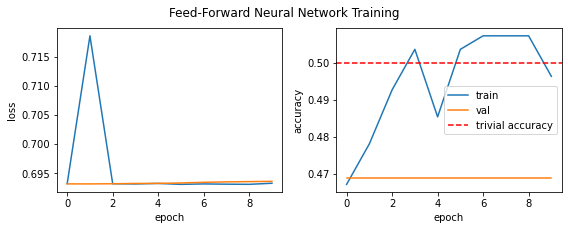

In [22]:
def plot_history(history, name):
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    for i, metric in enumerate(['loss', 'accuracy']):
        ax[i].plot(history.history[metric], label='train')
        ax[i].plot(history.history[f'val_{metric}'], label='val')
        if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='trivial accuracy')
        ax[i].set_xlabel('epoch')
        ax[i].set_ylabel(metric)
    plt.suptitle(f'{name} Training', y=1.05)
    plt.legend()
    plt.tight_layout()

plot_history(FFNN_history, 'Feed-Forward Neural Network')

In [23]:
### edTest(test_ffnn_acc) ###
FFNN_loss, FFNN_acc = FFNN.evaluate(img_generator, steps=15)
print(f'FFNN Test Accuracy: {FFNN_acc}')

15/15 [==============================] - 1s 45ms/step - loss: 0.6934 - accuracy: 0.4875
FFNN Test Accuracy: 0.48750001192092896


### CNN

The CNN offers two great advantages over the FFNN in this task:
1. Far Fewer Parameters

The FFNN had weights between _every_ input pixel and each node in the first dense layer. That's a lot of weights! By contrast, the weights learned by the first CNN layer are not a function of the size of the input image at all. They depend only on the size and number of filters we specify
2. Learning Translation Invariant Features

Features are detected by the filters, and these filters convolve around the entire image. This means they can recognize the particular feature they are tuned for no matter where it occurs in an image. The FFNN had no way of representing 'translated' features as being the same. It must learn each position independently!

In [31]:
### edTest(test_cnn_count_param) ###

CNN = Sequential()
CNN.add(Input(shape=(150, 150, 3)))
# specify a list of the number of filters for each convolutional layer
# you can try any number of convolutional layers with any number of filters in each
# Ex: for n_filters in [a,b,c,...] where a, b, c, etc. are ints
for n_filters in [1, 2, 3]:
    CNN.add(Conv2D(n_filters, kernel_size=3, activation='relu'))
    # add a layer to further reduce the dimensionality
    # Hint: this layer has no learned parameters of its own
    CNN.add(MaxPool2D((2, 2)))
# fill in the layer needed between our 2d convolutional layers and the dense layer
CNN.add(Flatten())
# specify the number of nodes in the dense layer before the output
CNN.add(Dense(64, activation='relu'))
CNN.add(Dense(1, activation='sigmoid'))
    
CNN.compile(loss='binary_crossentropy', metrics=['accuracy'])

Think about how do your choices affect the number of parameters.

Work to get above 95% accuracy after 10 epochs with 100k parameters or fewer.

In [32]:
CNN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 1)       28        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 2)         20        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 2)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 3)         57        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 3)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 867)             

In [33]:
CNN_history = CNN.fit(
        img_generator,
        steps_per_epoch=300 // BATCH_SIZE,
        epochs=10,
        validation_data=img_generator,
        validation_steps=75// BATCH_SIZE)

Train for 18 steps, validate for 4 steps
Epoch 1/10
18/18 [==============================] - 3s 156ms/step - loss: 0.6508 - accuracy: 0.6460 - val_loss: 0.5285 - val_accuracy: 0.8750
Epoch 2/10
18/18 [==============================] - 4s 197ms/step - loss: 0.4729 - accuracy: 0.8212 - val_loss: 0.3801 - val_accuracy: 0.8594
Epoch 3/10
18/18 [==============================] - 2s 129ms/step - loss: 0.3662 - accuracy: 0.8759 - val_loss: 0.2808 - val_accuracy: 0.9219
Epoch 4/10
18/18 [==============================] - 2s 129ms/step - loss: 0.2642 - accuracy: 0.9444 - val_loss: 0.2021 - val_accuracy: 0.9688
Epoch 5/10
18/18 [==============================] - 2s 94ms/step - loss: 0.2298 - accuracy: 0.9307 - val_loss: 0.1684 - val_accuracy: 0.9844
Epoch 6/10
18/18 [==============================] - 2s 95ms/step - loss: 0.1600 - accuracy: 0.9672 - val_loss: 0.1843 - val_accuracy: 0.9219
Epoch 7/10
18/18 [==============================] - 1s 82ms/step - loss: 0.1252 - accuracy: 0.9745 - val_loss

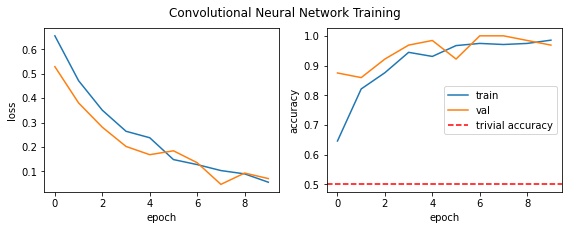

In [34]:
plot_history(CNN_history, 'Convolutional Neural Network')

In [35]:
### edTest(test_cnn_acc) ###
CNN_loss, CNN_acc = CNN.evaluate(img_generator, steps=15)
print(f'CNN Test Accuracy: {CNN_acc}')

15/15 [==============================] - 1s 79ms/step - loss: 0.0497 - accuracy: 0.9833
CNN Test Accuracy: 0.9833333492279053
